# Excercise - Creating our own custom Model

This is a notebook that provides a quick overview of how to create your own custom model. You will be creating a simple model.
You will be utilizing Keras and Tensorflow


## Water Quality Dataset

This dataset contains water quality measurements and assessments related to potability, which is the suitability of water for human consumption. The dataset's primary objective is to provide insights into water quality parameters and assist in determining whether the water is potable or not. Each row in the dataset represents a water sample with specific attributes, and the "Potability" column indicates whether the water is suitable for consumption.

https://www.kaggle.com/datasets/uom190346a/water-quality-and-potability?select=water_potability.csv


**Importing necessary modules**


In [264]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

**Loading the dataset and understanding the data**

In [265]:
df = pd.read_csv("/content/data/water_potability.csv")

# Displaying the first few rows
df.head()


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


**From the first few rows displayed, we are aready noticing NaN values, we need to explore this further !**

In [266]:
# Checking for missing values
print(df.isnull().sum())


ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


**We found out that our data has missing information so we are going to fix that by filling them with column means.After that we will verify to check if we have any missing values remaining.**

In [267]:
# Filling missing values with column means
df.fillna(df.mean(), inplace=True)

# Verifying no missing values remain
print(df.isnull().sum())


ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


**To understand our data and its relations we are going to create a correlation matrix.**

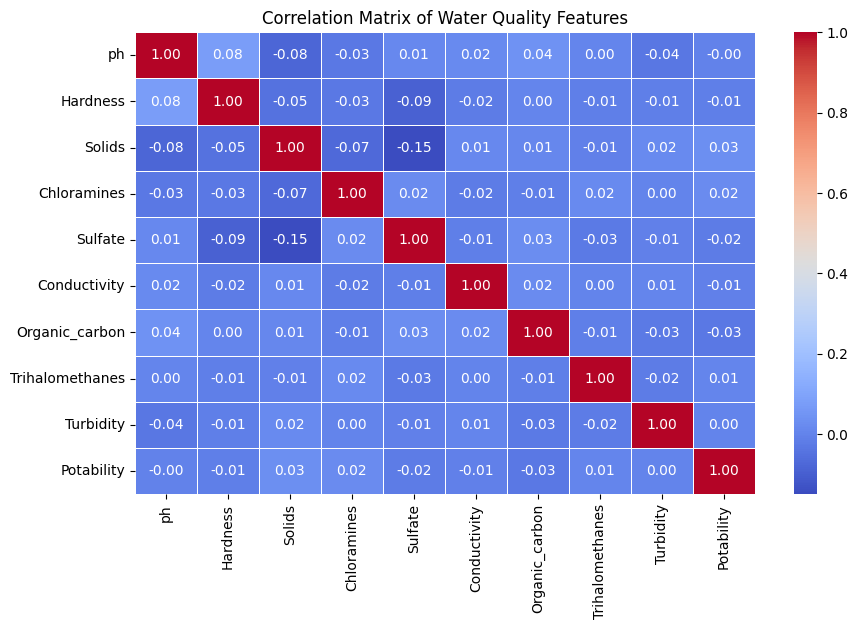

In [268]:
corr_matrix = df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Water Quality Features")
plt.show()

**Our dataset looks imbalanced ... Let's verify so that we understand the class distribution in percentage form**

In [269]:
counts = df['Potability'].value_counts()
total = counts.sum()

print(f"Examples:\n  Total: {total}\n  zero: {counts[0]} ({counts[0] / total * 100:.2f}% of total)\n  one: {counts[1]} ({counts[1] / total * 100:.2f}% of total)")


Examples:
  Total: 3276
  zero: 1998 (60.99% of total)
  one: 1278 (39.01% of total)


**From the above results, the dataset is imbalanced, with non-potable water (0) making up ~61% and potable water (1) making up ~39%. While this isn't a very big imbalance, it can still impact model performance.**

**Now we are going to define our feature X and target Y then split the data into 15% validation, 15% test and 70% train**

In [270]:
# Features (X) and Target (Y)
X = df.drop(columns=["Potability"])
Y = df["Potability"]

#Using StandardScaler for scaling:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Scale the features 'X'

from sklearn.model_selection import train_test_split

# Step 1: Split the data into 70% training and 30% temporary (validation + test) sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, Y, test_size=0.3, random_state=42, stratify=Y)

# Step 2: Split the temporary set into 50% validation and 50% test sets (15% each of the total dataset)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

# Step 3: Print the sizes of each dataset to confirm the splits
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Testing set: {X_test.shape}")

Training set: (2293, 9), Validation set: (491, 9), Testing set: (492, 9)


# Audry's model

In [271]:
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

**In defining my model, I will use L2 regularization to help prevent overfitting by penalizing large weights and the Adam optimizer to adjust the model’s weights effectively during training.**

In [272]:
def audry_model(X_train, Y_train, X_val, Y_val):
    # Model Architecture
    model = models.Sequential()

    # First Dense layer with L2 regularization and ReLU activation
    model.add(layers.Dense(128, activation='relu',
                           kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)))
    model.add(layers.Dropout(0.3))  # Dropout to prevent overfitting

    # Second Dense layer with L2 regularization and ReLU activation
    model.add(layers.Dense(64, activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.3))  # Dropout to prevent overfitting

    # Third Dense layer with L2 regularization and ReLU activation
    model.add(layers.Dense(32, activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.3))  # Dropout to prevent overfitting

    # Output layer with sigmoid activation for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid activation for probability output

    # Compiling the model with Adam optimizer, binary crossentropy loss, and accuracy metric
    optimizer = Adam(learning_rate=0.001)  # Learning rate set to 0.001
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Early stopping to prevent overfitting by monitoring the validation loss
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Model Summary
    model.summary()

    return model # Return the compiled model

**Training the model**

In [273]:
from sklearn.metrics import classification_report # Import classification_report
from matplotlib import pyplot  # Import pyplot

# Create and train the model
model = audry_model(X_train, Y_train, X_val, Y_val) # Pass the correct data splits to the function
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=300, batch_size=128, callbacks=[early_stopping])




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                     │ (None, 128)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,649 (45.50 KB)

 Trainable params: 11,649 (45.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5916 - loss: 2.0673 - val_accuracy: 0.6090 - val_loss: 1.8415
Epoch 2/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5910 - loss: 1.7887 - val_accuracy: 0.6110 - val_loss: 1.5968
Epoch 3/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5975 - loss: 1.5509 - val_accuracy: 0.6110 - val_loss: 1.3947
Epoch 4/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5975 - loss: 1.3573 - val_accuracy: 0.6110 - val_loss: 1.2322
Epoch 5/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6035 - loss: 1.2043 - val_accuracy: 0.6110 - val_loss: 1.1046
Epoch 6/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6140 - loss: 1.0766 - val_accuracy: 0.6110 - val_loss: 1.0035
Epoch 7/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6090 - loss: 0.9825 - val_accuracy: 0.6110 - val_loss: 0.9246
Epoch 8/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6059 - loss: 0.9109 - val_accuracy: 0.6110 

**Evaluating the model**

In [274]:
# evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(Y_test, y_pred))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.67      0.93      0.78       300
           1       0.74      0.30      0.42       192

    accuracy                           0.68       492
   macro avg       0.71      0.62      0.60       492
weighted avg       0.70      0.68      0.64       492



**Plotting train history**

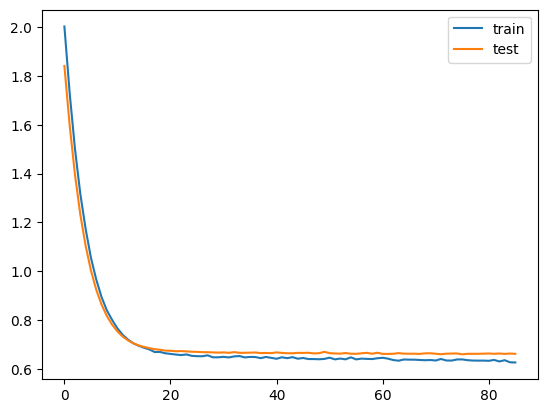

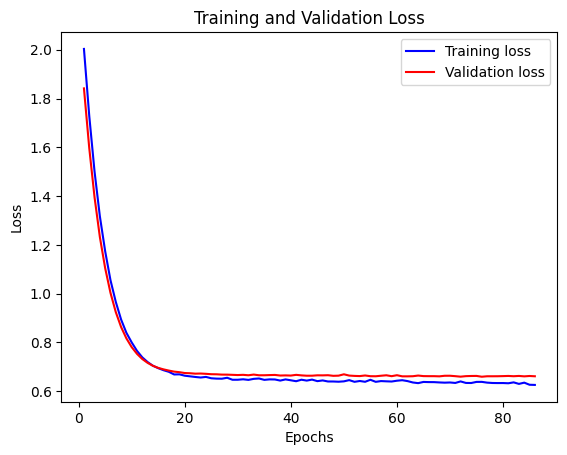

In [275]:
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Access training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy'] # Access training accuracy
val_accuracy = history.history['val_accuracy'] # Access validation accuracy

epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')


plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


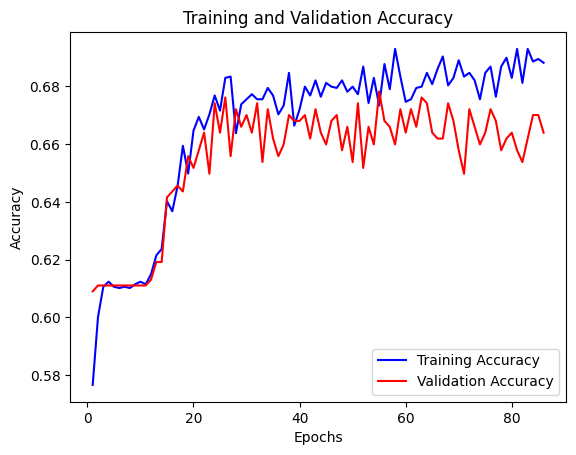

In [276]:


# Plotting Accuracy Curves
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Evaluation , let's check my model's accuracy okay...**

In [277]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 68.50%
